In [1]:
# Download dependencies

!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip


!unzip -qq utils.zip
!rm utils.zip
!rm -r __MACOSX

!ls

gdrive.py  sutils.py  Transfer_Learning.ipynb


In [2]:
# Import libraries

#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

from sutils import *
import os, json
from glob import glob

from tensorflow.python.keras.applications.inception_v3 import InceptionV3
#from tensorflow.python.keras.applications import VGG16

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
from tensorflow.python.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Download dataset

!wget -qq https://www.dropbox.com/s/bgv2q2isj6fni5o/data.zip
  
!unzip -qq data.zip
!rm data.zip
!rm -r __MACOSX

!ls

data  gdrive.py  sutils.py  sutils.pyc	Transfer_Learning.ipynb


In [4]:
!ls data

dogscats  imagenet


In [5]:
path = "./data/dogscats/"

In [6]:
img_width, img_height = 299, 299
train_data_dir = "./data/dogscats/train/"
validation_data_dir = "./data/dogscats/valid/"

nb_train_samples = 4125
nb_validation_samples = 2000 
batch_size = 16
epochs = 5

In [7]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


This will download the Inception weights from https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [8]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [9]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [10]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

In [11]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [13]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d_1
False
batch_normalization_1
False
activation_1
False
conv2d_2
False
batch_normalization_2
False
activation_2
False
conv2d_3
False
batch_normalization_3
False
activation_3
False
max_pooling2d_1
False
conv2d_4
False
batch_normalization_4
False
activation_4
False
conv2d_5
False
batch_normalization_5
False
activation_5
False
max_pooling2d_2
False
conv2d_9
False
batch_normalization_9
False
activation_9
False
conv2d_7
False
conv2d_10
False
batch_normalization_7
False
batch_normalization_10
False
activation_7
False
activation_10
False
average_pooling2d_1
False
conv2d_6
False
conv2d_8
False
conv2d_11
False
conv2d_12
False
batch_normalization_6
False
batch_normalization_8
False
batch_normalization_11
False
batch_normalization_12
False
activation_6
False
activation_8
False
activation_11
False
activation_12
False
mixed0
False
conv2d_16
False
batch_normalization_16
False
activation_16
False
conv2d_14
False
conv2d_17
False
batch_normalization_14
False
batch_normalization_17
F

In [14]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
batch_test = train_generator.next()

print(len(batch_test[1][0]))
print(len(batch_test[0][0]))
batch_test[1][2]

2
299


array([0., 1.], dtype=float32)

In [16]:
# Train the model 
model.fit_generator( train_generator, steps_per_epoch = 80,
epochs = epochs,
validation_data = validation_generator,
validation_steps = 10)

Epoch 1/5
80/80 [==============================] - 275s - loss: 0.5178 - acc: 0.8172 - val_loss: 0.0863 - val_acc: 0.9750
Epoch 2/5
80/80 [==============================] - 279s - loss: 0.2121 - acc: 0.9078 - val_loss: 0.1214 - val_acc: 0.9656
Epoch 3/5
80/80 [==============================] - 269s - loss: 0.2166 - acc: 0.9039 - val_loss: 0.1221 - val_acc: 0.9469
Epoch 4/5
80/80 [==============================] - 265s - loss: 0.2118 - acc: 0.9141 - val_loss: 0.1265 - val_acc: 0.9441
Epoch 5/5
80/80 [==============================] - 285s - loss: 0.1568 - acc: 0.9383 - val_loss: 0.0948 - val_acc: 0.9625


In [17]:
metrics = model.evaluate_generator(validation_generator,10,10,workers=1)
print("model accuracy:",metrics[1])

('model accuracy:', 0.940625)


In [18]:
model.save('cats-dogs.hdf5')

In [19]:
model = load_model('cats-dogs.hdf5')

In [20]:
image_path = './data/dogscats/test1/'

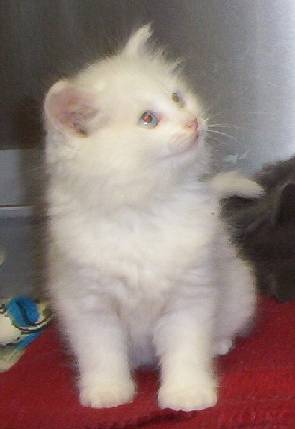

In [21]:
from IPython.display import Image

Image(image_path+'84.jpg')

In [22]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

#img_path = os.path.join(image_path, '50.jpg')
img_path = os.path.join(image_path, '84.jpg')

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

('Input image shape:', (1, 224, 224, 3))


In [23]:
preds = model.predict(x)
print('Predicted:', preds)

('Predicted:', array([[1.0000000e+00, 8.5965923e-10]], dtype=float32))


In [24]:
result= np.argmax(preds)
if result==0:
    print("Its a cat")
else:
    print("Its a dog")

Its a cat


In [26]:
# remove the save model and data because of size
!rm -rf data/
!rm cats-dogs.hdf5

gdrive.py  sutils.py  sutils.pyc  Transfer_Learning.ipynb
